Just going to use `chb01_03.edf` initially as it contains a seizure.

In [33]:
import mne

raw = mne.io.read_raw_edf("chb01_03.edf")
raw.load_data()

Extracting EDF parameters from /home/angus/Insync/angus.logan@baronsview.com/Google Drive/@1Uni/work/year4/cs408/cs408-python/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\angus\AppData\Local\Temp\ipykernel_21068\3921138937.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf("dataset/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf")


<RawEDF | chb01_03.edf, 23 x 921600 (3600.0 s), ~161.7 MB, data loaded>

Effective window size : 8.000 (s)


/home/angus/Insync/angus.logan@baronsview.com/Google Drive/@1Uni/work/year4/cs408/cs408-python/venv/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


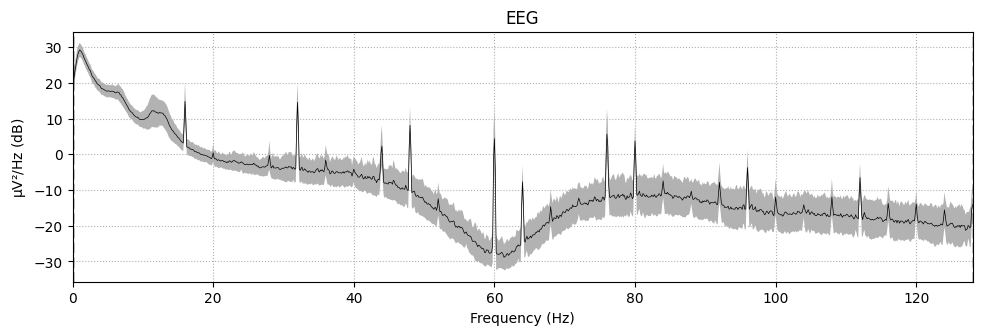

In [21]:
spectrum = raw.compute_psd()
spectrum.plot(average=True)

The peak at 60Hz is caused by the power line interference, as the data was recorded at the Boston Children's Hospital in America (where the grid runs at 60Hz). The peak at 120Hz is also caused by this, as it's the second harmonic of the grid.

The other peaks, especially those around the 30Hz mark could be related to the heartbeat of the patient, however I'm not sure if these can be properly identified without gradiometers or magnetometers.

I'm going to apply a bandpass filter to remove frequencies below 0.5Hz and above 34Hz (both figures found in lit review). This will remove any low  and high frequency noise from the data - "most brain activity occurs between 3 and 29Hz".

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 34 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 34.00 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 34.05 Hz)
- Filter length: 8449 samples (33.004 s)

Effective window size : 8.000 (s)


/home/angus/Insync/angus.logan@baronsview.com/Google Drive/@1Uni/work/year4/cs408/cs408-python/venv/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


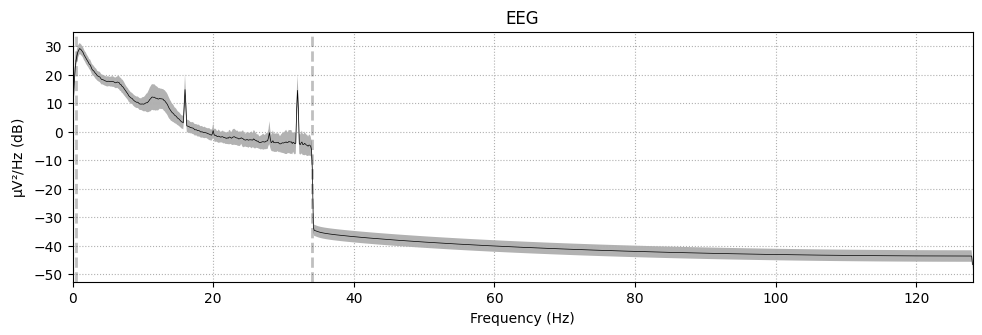

In [45]:
# perform a notch filter for the power line interference and the second harmonic
filtered = raw.copy().filter(l_freq=0.5, h_freq=34, )
spectrum = filtered.compute_psd()
spectrum.plot(average=True)

Next I'll apply ICA to try and repair artefacts.

In [35]:
from mne.preprocessing.ica import ICA

ica = ICA(n_components=10, max_iter="auto")
ica.fit(filtered)

Fitting ICA to data using 23 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 7.9s.


Method,fastica
Fit,37 iterations on raw data (921600 samples)
ICA components,10
Available PCA components,23
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=10, n_times=921600
    Range : 0 ... 921599 =      0.000 ...  3599.996 secs
Ready.


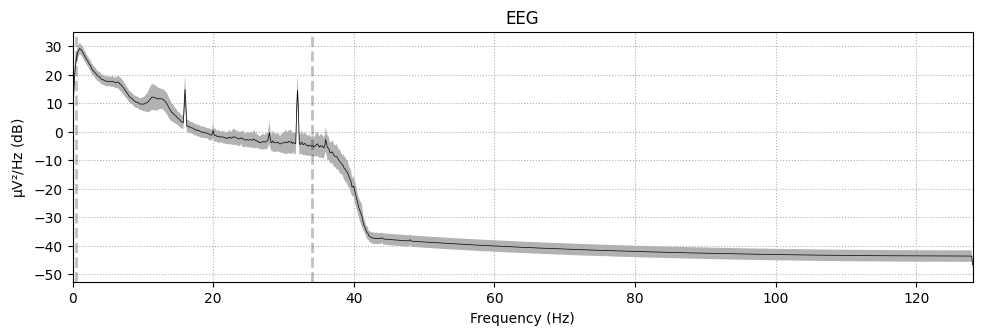

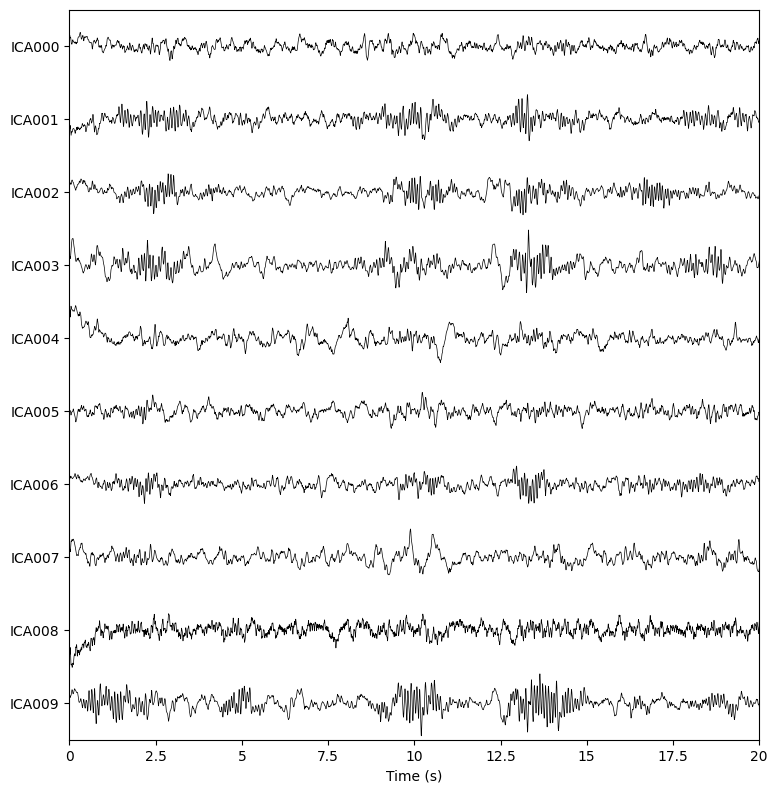

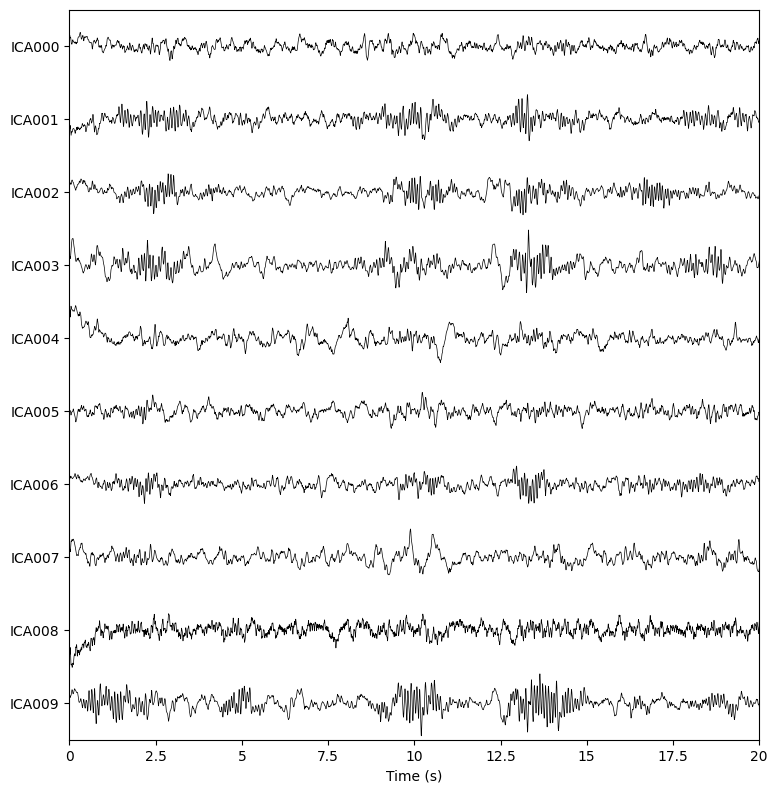

In [36]:
ica.plot_sources(filtered, show_scrollbars=False)

In [39]:
ecg_idx_auto, scores = ica.find_bads_ecg(filtered, ch_name="T7-P7")
print(ecg_idx_auto)

Using threshold: 0.32 for CTPS ECG detection
Using channel T7-P7 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2560 samples (10.000 s)

Number of ECG events detected : 5014 (average pulse 83 / min.)
Not setting metadata
5014 matching events found
No baseline correction applied
Using data from preloaded Raw for 5014 events and 257 original time points ...
0 bad epochs dropped
[]


Applying ICA to Raw instance


    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 23 PCA components


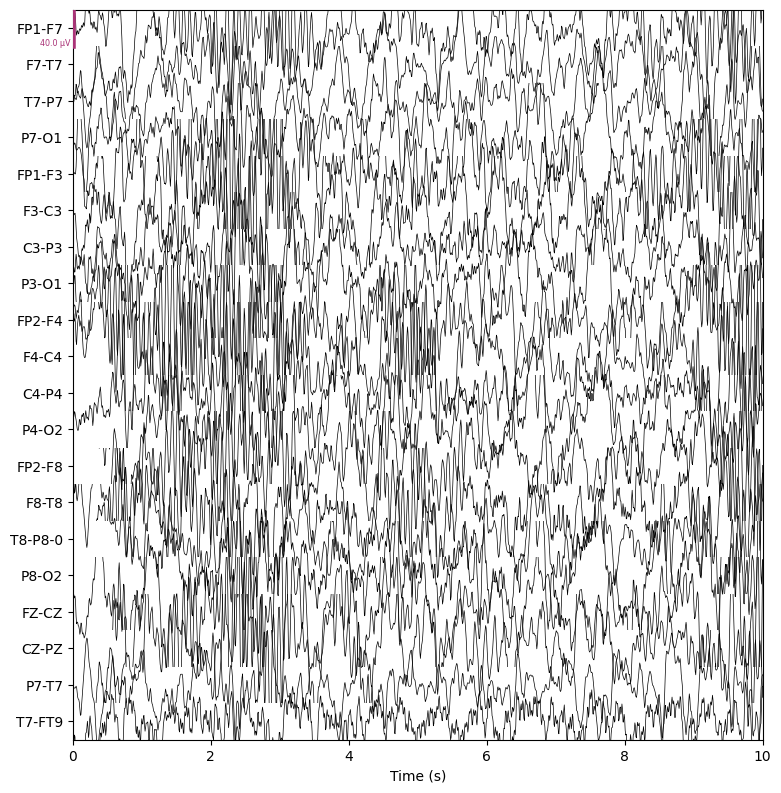

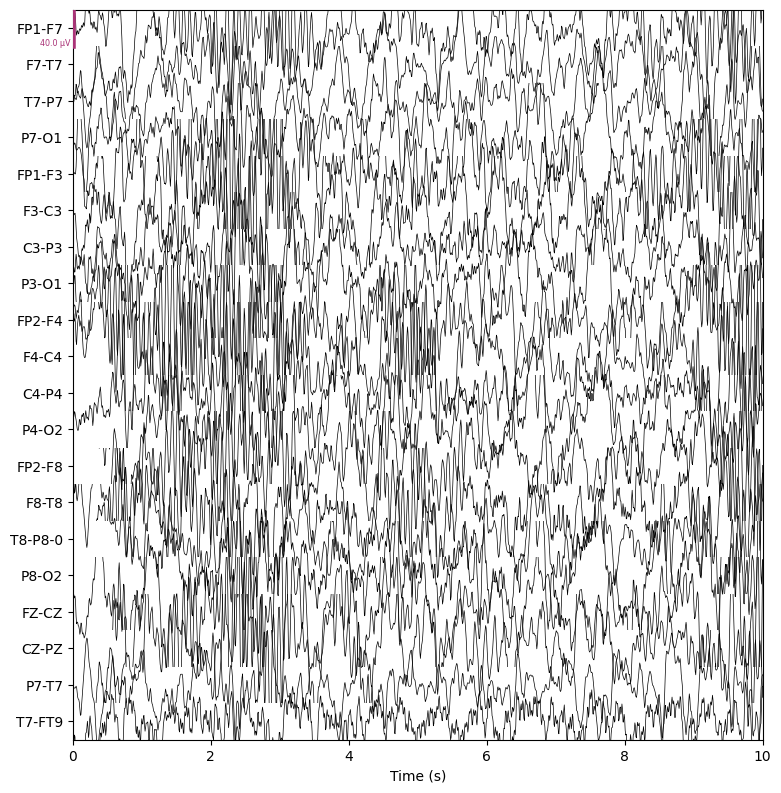

In [25]:
filtered_ica = filtered.copy()
ica.apply(filtered_ica)

filtered_ica.plot(show_scrollbars=False, title="EEG Data after Highpass and ICA Repair")

Effective window size : 8.000 (s)


c:\Users\angus\Documents\cs408-eeg-python\venv\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


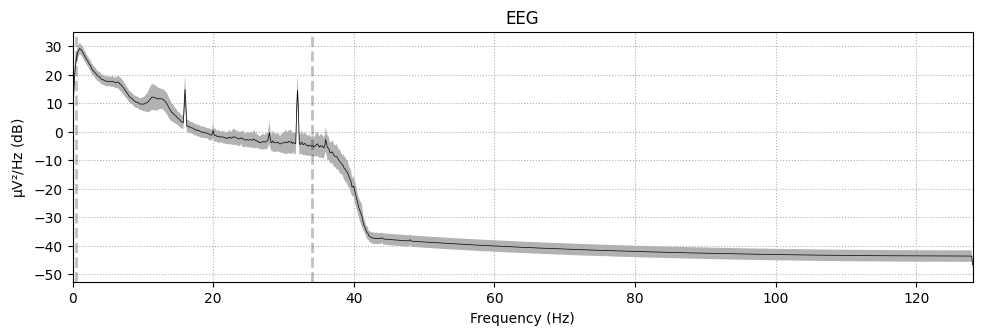

In [26]:
ica_psd = filtered_ica.compute_psd()
ica_psd.plot(average=True)

Effective window size : 8.000 (s)


c:\Users\angus\Documents\cs408-eeg-python\venv\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


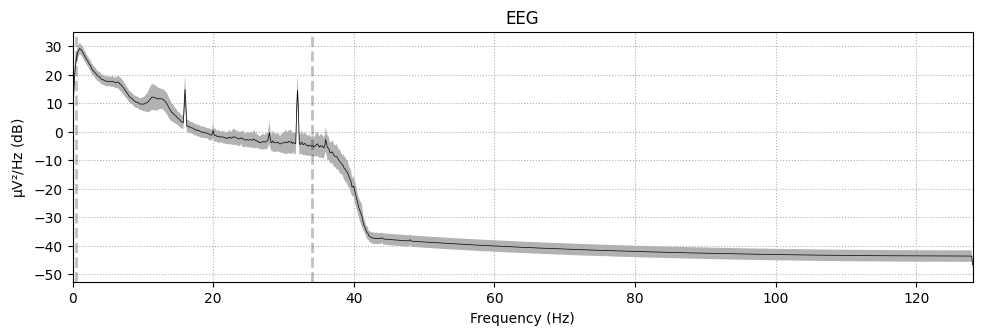

In [27]:
filtered_psd = filtered.compute_psd()
filtered_psd.plot(average=True)

I can't see much if any difference between the ICA and non-ICA PSD graphs. I'm not sure if the ICA actually did anything. Visually comparing the pre and post ICA EEG data also doesn't show much, if any, difference either.

In [28]:
# filtered.export("preprocessing-samples/filtered.edf")
filtered_ica.export("preprocessing-samples/ica-10.edf", overwrite=True)

Overwriting existing file.


Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 23 PCA components


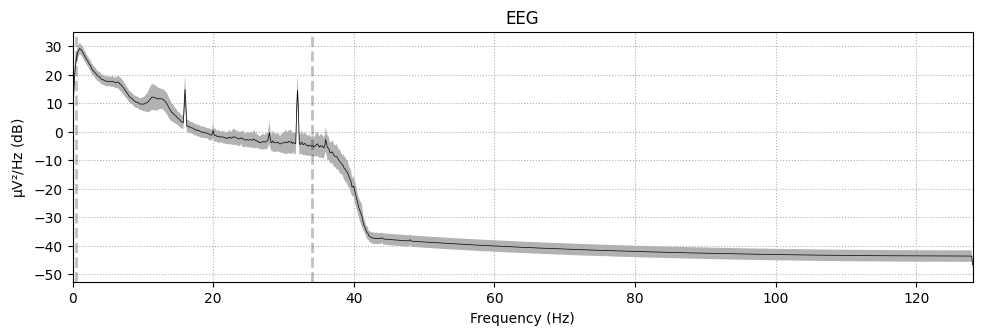

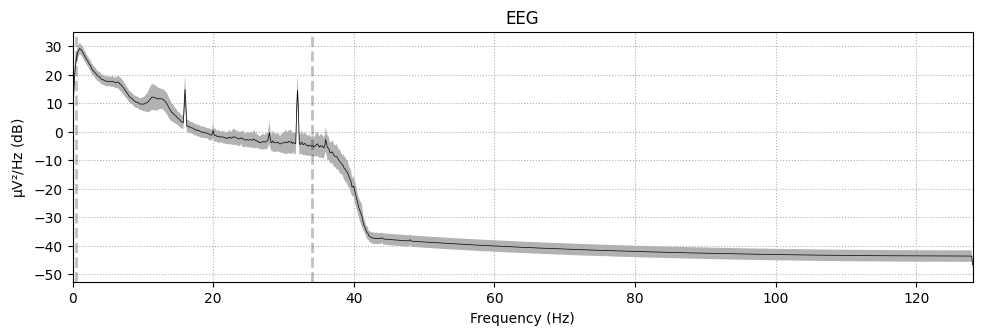

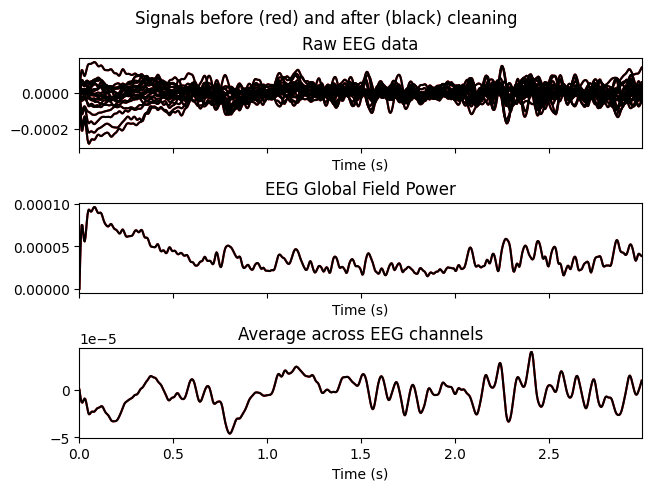

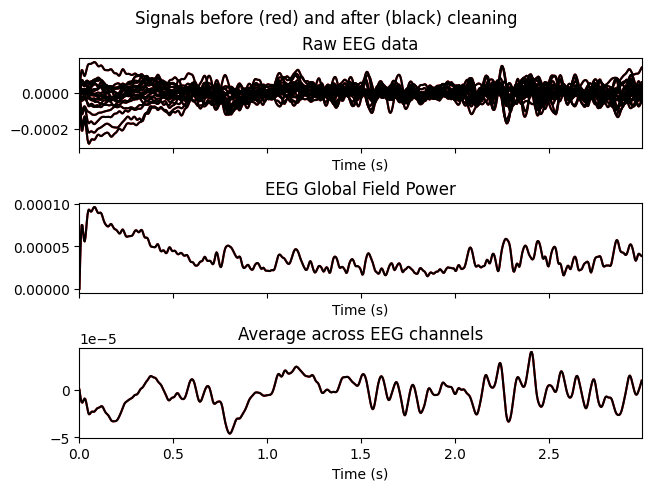

In [29]:
ica.plot_overlay(filtered)

In [30]:
import numpy as np
epochs = mne.make_fixed_length_epochs(filtered_ica, duration=1, overlap=0.96)
print("done")
epochs_np_array = epochs.get_data()
# print(epochs_np_array.shape)

Not setting metadata
89976 matching events found
No baseline correction applied
0 projection items activated
done
Using data from preloaded Raw for 89976 events and 256 original time points ...
0 bad epochs dropped


In [31]:
np.save("chb01-03_epochs_np_array", epochs_np_array)

In [40]:
raw.compute_psd().plot_topomap()

Effective window size : 8.000 (s)


C:\Users\angus\AppData\Local\Temp\ipykernel_21068\3849279380.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'T7', 'FP1', 'T8', 'FP2', 'P7'}. Applying running numbers for duplicates.
  raw.compute_psd().plot_topomap()


RuntimeError: No digitization points found.